In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from monty.serialization import dumpfn, loadfn
from collections import defaultdict

In [3]:
from ase.filters import FrechetCellFilter
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.optimize import LBFGS
from pymatgen.io.ase import AseAtomsAdaptor

predictor = pretrained_mlip.get_predict_unit("uma-m-1p1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omat") # use "omat" - inorganic materials

In [106]:
def relaxation_defect(structure): # takes in pymatgen structure
    atoms = structure.to_ase_atoms()
    atoms.calc = calc

    opt = LBFGS(atoms) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 100)

    structure1 = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return structure1, energy 

Load in all relaxed primitive Al Oxide structures
<br>Loop through all Al oxides 
<br>Create function using doped and shakenbreak for each structure
<br>Create function that loops over unpertubed and all disortions and uses MLIP to calc energies - append structure and energies to data dict
<br>get energy difference from unperturbed for each Al oxide and append to dictionary or list for bar chart - can do this manually in loop 
<br>dumpfn the data dict and list of energy differences, or maybe add energy diff to data dict as 'delta_e' key?
<br>Plot bar chart for all metal oxides and their energy relative to unperturbed

In [5]:
from doped.generation import DefectsGenerator
from shakenbreak.input import Distortions

In [51]:
def create_defect(structure):
    defect_gen = DefectsGenerator(structure, extrinsic="Cr", interstitial_gen_kwargs=False) # set large super cell 25 Angstroms
    valid_keys = []
    for key in defect_gen.keys():
        if  key[:5] == 'Cr_Al' and key[-1] == '0':
            valid_keys.append(key)
    Dist = Distortions(
        defect_entries = {key: defect_gen[key] for key in valid_keys}, # NO Cr_Al_0 for Al2(SO4)3
        # oxidation_states={} # oxidation states predicted are good for now
    )
    distorted_defects_dict, Dist.distortion_metadata = Dist.apply_distortions()
    unperturbed_structures = {}
    distortions = {}
    for key in valid_keys:
        unperturbed_structures[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['Unperturbed']
        distortions[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['distortions']

    return dict(unperturbed_structures), dict(distortions), defect_gen.bulk_supercell

In [63]:
def get_energy(unperturbed_structures, distortions, supercell):
    data = defaultdict(dict)
    supercell_struct, supercell_e = relaxation_defect(supercell)
    data['supercell'] = {
        'structure': supercell_struct,
        'energy': supercell_e
    }
    
    for site, unperturbed_structure in unperturbed_structures.items():
        data[site] = defaultdict(dict)
        data[site]['unperturbed'] = defaultdict(dict)
        unperturbed_structure1, unp_energy = relaxation_defect(unperturbed_structure)
        data[site]['unperturbed'] = {
        'structure':unperturbed_structure1,
        'energy': unp_energy,
        'distortion_amount':'N/A'
        }
        data[site]['distortions'] = defaultdict(dict)
        for key, structure in distortions[site].items():
            structure1, energy = relaxation_defect(structure)
            if key != 'Rattled':
                distortion_amount = float(key.split("_")[-1].replace("%", "").replace("-", "-"))/100
            else:
                distortion_amount = 0
            data[site]['distortions'][key] = {
                'structure': structure1,
                'energy': energy,
                'distortion_amount': distortion_amount,
                'delta_e': energy - unp_energy
            }
    
    return dict(data)

In [64]:
Al_prim = loadfn('../data/relaxed_Al_prim.json')
del Al_prim['mp-554152']

In [107]:
data = {}
for key, val in Al_prim.items():
    unperturbed_structures, distortions, supercell = create_defect(val['structure'])
    mini_data = get_energy(unperturbed_structures, distortions, supercell) # add in host supercell relaxation
    data[key] = mini_data


Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:16,   1.31it/s]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_Al                      [+1,0,-1,-2,-3]        [0.384,0.137,0.125]  4e
v_P_C1_O1.49              [+1,0,-1,-2,-3,-4,-5]  [0.297,0.164,0.484]  4e
v_P_C1_O1.50O1.60         [+1,0,-1,-2,-3,-4,-5]  [0.355,0.456,0.282]  4e
v_P_C1_O1.50O1.61         [+1,0,-1,-2,-3,-4,-5]  [0.085,0.612,0.287]  4e
v_O_C1_P1.49              [+2,+1,0,-1]           [0.323,0.257,0.090]  4e
v_O_C1_P1.50Al1.90O2.52   [+2,+1,0,-1]           [0.695,0.158,0.149]  4e
v_O_C1_P1.50Al1.90O2.53a  [+2,+1,0,-1]           [0.077,0.114,0.106]  4e
v_O_C1_P1.50Al1.90O2.53b  [+2,+1,0,-1]           [0.335,0.381,0.392]  4e
v_O_C1_P1.50Al1.91        [+2,+1,0,-1]           [0.432,0.155,0.359]  4e
v_O_C1_P1.50Al1.92        [+2,+1,0,-1]           [0.446,0.015,0.164]  4e
v_O_C1_P1.60              [+2,+1,0,-1]           [0.353,0.421,0.100]  4e
v_O_C1_P1.61              [+2,+1,0,-1] 

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  13.37it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 12:40:01    -1143.390121        0.007062
       Step     Time          Energy          fmax
LBFGS:    0 12:40:02    -1143.717672        2.009304
LBFGS:    1 12:40:03    -1143.879995        1.347986
LBFGS:    2 12:40:04    -1144.017660        0.589578
LBFGS:    3 12:40:05    -1144.067297        0.389210
LBFGS:    4 12:40:06    -1144.095724        0.314214
LBFGS:    5 12:40:07    -1144.116903        0.181302
LBFGS:    6 12:40:08    -1144.128133        0.212546
LBFGS:    7 12:40:09    -1144.138509        0.196041
LBFGS:    8 12:40:10    -1144.146001        0.100310
LBFGS:    9 12:40:11    -1144.149984        0.106464
LBFGS:   10 12:40:12    -1144.152380        0.071766
LBFGS:   11 12:40:13    -1144.154272        0.081778
LBFGS:   12 12:40:14    -1144.155889        0.067601
LBFGS:   13 12:40:15    -

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:23,   4.21it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Li         [+1,0,-1]          [0.000,0.000,0.000]  3a
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  3b
v_O          [+2,+1,0,-1]       [0.000,0.000,0.238]  6c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Li_Al            [0,-1,-2]           [0.000,0.000,0.500]  3b
Li_O             [+3,+2,+1,0]        [0.000,0.000,0.238]  6c
Al_Li            [+2,+1,0]           [0.000,0.000,0.000]  3a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c
O_Li             [0,-1,-2,-3]        [0.000,0.000,0.000]  3a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  3b
Cr_Li            [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.000]  3a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.500]  3b
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c

The number in the Wycko

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   7.36it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 12:42:11     -688.213778        0.002975
       Step     Time          Energy          fmax
LBFGS:    0 12:42:12     -688.844201        1.655003
LBFGS:    1 12:42:13     -689.032982        1.009566
LBFGS:    2 12:42:14     -689.166420        0.202945
LBFGS:    3 12:42:15     -689.173867        0.127182
LBFGS:    4 12:42:16     -689.178978        0.080032
LBFGS:    5 12:42:17     -689.181664        0.058402
LBFGS:    6 12:42:18     -689.183220        0.047421
LBFGS:    7 12:42:19     -689.183876        0.026632
LBFGS:    8 12:42:20     -689.184182        0.022117
LBFGS:    9 12:42:21     -689.184517        0.018842
LBFGS:   10 12:42:22     -689.184853        0.020277
LBFGS:   11 12:42:24     -689.185082        0.012921
LBFGS:   12 12:42:25     -689.185189        0.010800
LBFGS:   13 12:42:26     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:15,   6.31it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.500,0.000,0.412]  2b
v_Cl         [+1,0,-1]          [0.000,0.000,0.233]  2a
v_O          [+2,+1,0,-1]       [0.000,0.000,0.541]  2a

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.233]  2a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.541]  2a
Cl_Al            [0,-1,-2,-3,-4]     [0.500,0.000,0.412]  2b
Cl_O             [+1,0]              [0.000,0.000,0.541]  2a
O_Al             [0,-1,-2,-3,-4,-5]  [0.500,0.000,0.412]  2b
O_Cl             [0,-1]              [0.000,0.000,0.233]  2a
Cr_Al            [+3,+2,+1,0,-1]     [0.500,0.000,0.412]  2b
Cr_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.233]  2a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.541]  2a

The number in the Wycko

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  16.80it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 12:43:29     -317.005174        0.004452
       Step     Time          Energy          fmax
LBFGS:    0 12:43:30     -318.088222        2.197256
LBFGS:    1 12:43:31     -318.238125        1.029233
LBFGS:    2 12:43:32     -318.308296        0.358116
LBFGS:    3 12:43:33     -318.322193        0.257480
LBFGS:    4 12:43:33     -318.335323        0.159904
LBFGS:    5 12:43:34     -318.339680        0.126013
LBFGS:    6 12:43:35     -318.342701        0.089798
LBFGS:    7 12:43:36     -318.344444        0.079702
LBFGS:    8 12:43:37     -318.345840        0.091141
LBFGS:    9 12:43:38     -318.346752        0.062857
LBFGS:   10 12:43:39     -318.347343        0.048656
LBFGS:   11 12:43:40     -318.347790        0.036940
LBFGS:   12 12:43:41     -318.348221        0.035692
LBFGS:   13 12:43:42     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:23,   4.32it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Sm         [+1,0,-1,-2,-3]    [0.009,0.250,0.464]  4c
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  4a
v_O_C1       [+2,+1,0,-1]       [0.281,0.038,0.217]  8d
v_O_Cs       [+2,+1,0,-1]       [0.571,0.250,0.513]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Sm_Al            [+1,0,-1]           [0.000,0.000,0.000]  4a
Sm_O_C1          [+5,+4,+3,+2,+1,0]  [0.281,0.038,0.217]  8d
Sm_O_Cs          [+5,+4,+3,+2,+1,0]  [0.571,0.250,0.513]  4c
Al_Sm            [+1,0,-1]           [0.009,0.250,0.464]  4c
Al_O_C1          [+5,+4,+3,+2,+1,0]  [0.281,0.038,0.217]  8d
Al_O_Cs          [+5,+4,+3,+2,+1,0]  [0.571,0.250,0.513]  4c
O_Sm             [0,-1,-2,-3,-4,-5]  [0.009,0.250,0.464]  4c
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.000]  4a
Cr_Sm            [+3,+2,+1,0,

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  11.71it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 12:44:51     -634.838016        0.008660
       Step     Time          Energy          fmax
LBFGS:    0 12:44:52     -635.484293        1.691507
LBFGS:    1 12:44:53     -635.658563        0.923849
LBFGS:    2 12:44:54     -635.747705        0.242635
LBFGS:    3 12:44:54     -635.758737        0.171572
LBFGS:    4 12:44:55     -635.772379        0.130761
LBFGS:    5 12:44:56     -635.776270        0.092993
LBFGS:    6 12:44:57     -635.779657        0.066689
LBFGS:    7 12:44:58     -635.781351        0.047175
LBFGS:    8 12:44:59     -635.783060        0.044544
LBFGS:    9 12:45:00     -635.784479        0.045209
LBFGS:   10 12:45:01     -635.785608        0.039573
LBFGS:   11 12:45:02     -635.786203        0.025287
LBFGS:   12 12:45:03     -635.786554        0.022011
LBFGS:   13 12:45:04     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:22,   4.37it/s]


Vacancies       Guessed Charges        Conv. Cell Coords    Wyckoff
--------------  ---------------------  -------------------  ---------
v_Al            [+1,0,-1,-2,-3]        [0.000,0.500,0.000]  2b
v_W             [+1,0,-1,-2,-3,-4,-5]  [0.500,0.500,0.500]  2d
v_O_C2v_Al1.90  [+2,+1,0,-1]           [0.000,0.206,0.000]  4i
v_O_C2v_W1.95   [+2,+1,0,-1]           [0.194,0.500,0.500]  4h

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Al_O_C2v_Al1.90  [+5,+4,+3,+2,+1,0]           [0.000,0.206,0.000]  4i
Al_W             [0,-1,-2]                    [0.500,0.500,0.500]  2d
Al_O_C2v_W1.95   [+5,+4,+3,+2,+1,0]           [0.194,0.500,0.500]  4h
W_Al             [+3,+2,+1,0,-1]              [0.000,0.500,0.000]  2b
W_O_C2v_Al1.90   [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.000,0.206,0.000]  4i
W_O_C2v_W1.95    [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.194,0.500,0.500]  4h
O_Al             [0,-1,-2,-3,-4,-5]  

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   8.78it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 12:46:02     -634.856897        0.003154
       Step     Time          Energy          fmax
LBFGS:    0 12:46:02     -635.781142        1.800231
LBFGS:    1 12:46:03     -635.917626        0.878246
LBFGS:    2 12:46:04     -636.022835        0.337159
LBFGS:    3 12:46:05     -636.045565        0.255920
LBFGS:    4 12:46:06     -636.062607        0.204240
LBFGS:    5 12:46:07     -636.069645        0.079162
LBFGS:    6 12:46:08     -636.073328        0.060151
LBFGS:    7 12:46:09     -636.075115        0.065243
LBFGS:    8 12:46:10     -636.076508        0.056378
LBFGS:    9 12:46:11     -636.077515        0.035042
LBFGS:   10 12:46:12     -636.078158        0.030533
LBFGS:   11 12:46:13     -636.078512        0.022482
LBFGS:   12 12:46:14     -636.078749        0.018746
LBFGS:   13 12:46:15     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:59,   1.69it/s]


Vacancies                Guessed Charges        Conv. Cell Coords    Wyckoff
-----------------------  ---------------------  -------------------  ---------
v_K                      [+1,0,-1]              [0.682,0.182,0.058]  4e
v_Al                     [+1,0,-1,-2,-3]        [0.261,0.101,0.241]  4e
v_P_C1_O1.50             [+1,0,-1,-2,-3,-4,-5]  [0.374,0.403,0.169]  4e
v_P_C1_O1.52             [+1,0,-1,-2,-3,-4,-5]  [0.066,0.370,0.312]  4e
v_O_C1_P1.50             [+2,+1,0,-1]           [0.349,0.092,0.480]  4e
v_O_C1_P1.52             [+2,+1,0,-1]           [0.176,0.396,0.498]  4e
v_O_C1_P1.53Al1.92O2.49  [+2,+1,0,-1]           [0.476,0.000,0.225]  4e
v_O_C1_P1.53Al1.92O2.51  [+2,+1,0,-1]           [0.130,0.569,0.740]  4e
v_O_C1_P1.54Al1.92       [+2,+1,0,-1]           [0.415,0.259,0.246]  4e
v_O_C1_P1.54Al1.94       [+2,+1,0,-1]           [0.058,0.220,0.255]  4e
v_O_C1_P1.63             [+2,+1,0,-1]           [0.179,0.454,0.199]  4e

Substitutions             Guessed Charges          

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  15.28it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 12:47:48     -933.276199        0.009823
       Step     Time          Energy          fmax
LBFGS:    0 12:47:49     -933.769995        1.963576
LBFGS:    1 12:47:50     -933.917899        1.365810
LBFGS:    2 12:47:51     -934.028769        0.463637
LBFGS:    3 12:47:52     -934.082083        0.406383
LBFGS:    4 12:47:53     -934.110831        0.286413
LBFGS:    5 12:47:54     -934.132544        0.213447
LBFGS:    6 12:47:55     -934.145621        0.162899
LBFGS:    7 12:47:56     -934.153525        0.124990
LBFGS:    8 12:47:57     -934.159399        0.127160
LBFGS:    9 12:47:58     -934.165137        0.112113
LBFGS:   10 12:47:59     -934.170370        0.105282
LBFGS:   11 12:48:00     -934.173956        0.089730
LBFGS:   12 12:48:01     -934.176382        0.078730
LBFGS:   13 12:48:02     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:08,  12.12it/s]


Vacancies                Guessed Charges        Conv. Cell Coords    Wyckoff
-----------------------  ---------------------  -------------------  ---------
v_Cs_C2_O3.29            [+1,0,-1]              [0.462,0.462,0.000]  3a
v_Cs_C2_O3.30            [+1,0,-1]              [0.296,0.296,0.500]  3b
v_Al                     [+1,0,-1,-2,-3]        [0.686,0.686,0.500]  3b
v_N_C1_O1.24O1.33Al2.91  [+1,0,-1,-2,-3,-4,-5]  [0.238,0.558,0.254]  6c
v_N_C1_O1.24O1.33Al2.92  [+1,0,-1,-2,-3,-4,-5]  [0.345,0.095,0.099]  6c
v_N_C2                   [+1,0,-1,-2,-3,-4,-5]  [0.899,0.899,0.500]  3b
v_O_C1_N1.24O2.18O2.20   [+2,+1,0,-1]           [0.287,0.681,0.267]  6c
v_O_C1_N1.24O2.18O3.28   [+2,+1,0,-1]           [0.376,0.190,0.174]  6c
v_O_C1_N1.24O2.20        [+2,+1,0,-1]           [0.303,0.497,0.259]  6c
v_O_C1_N1.25             [+2,+1,0,-1]           [0.025,0.326,0.467]  6c
v_O_C1_N1.30             [+2,+1,0,-1]           [0.087,0.208,0.230]  6c
v_O_C1_N1.33Al1.87       [+2,+1,0,-1]           [0.1

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.2183187441565435 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:05,   5.16s/it]


       Step     Time          Energy          fmax
LBFGS:    0 12:49:43     -426.297192        0.009625
       Step     Time          Energy          fmax
LBFGS:    0 12:49:44     -427.363341        2.141240
LBFGS:    1 12:49:45     -427.534808        0.886450
LBFGS:    2 12:49:46     -427.634230        0.713813
LBFGS:    3 12:49:47     -427.707434        0.749421
LBFGS:    4 12:49:48     -427.783843        0.684343
LBFGS:    5 12:49:49     -427.834719        0.540545
LBFGS:    6 12:49:50     -427.849398        0.280368
LBFGS:    7 12:49:50     -427.852336        0.118578
LBFGS:    8 12:49:51     -427.853450        0.117335
LBFGS:    9 12:49:52     -427.855849        0.113920
LBFGS:   10 12:49:53     -427.858355        0.138598
LBFGS:   11 12:49:54     -427.861899        0.227684
LBFGS:   12 12:49:55     -427.864489        0.200560
LBFGS:   13 12:49:56     -427.865855        0.099241
LBFGS:   14 12:49:57     -427.866290        0.037083
LBFGS:   15 12:49:58     -427.866446        0.0300

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:42,   2.37it/s]


Vacancies                Guessed Charges    Conv. Cell Coords    Wyckoff
-----------------------  -----------------  -------------------  ---------
v_Al                     [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  6b
v_H_C1_O1.00H1.64Cl2.04  [+1,0,-1]          [0.117,0.185,0.139]  36f
v_H_C1_O1.00H1.64Cl2.05  [+1,0,-1]          [0.204,0.204,0.585]  36f
v_Cl                     [+1,0,-1]          [0.262,0.262,0.250]  18e
v_O                      [+2,+1,0,-1]       [0.045,0.150,0.085]  36f

Substitutions             Guessed Charges     Conv. Cell Coords    Wyckoff
------------------------  ------------------  -------------------  ---------
Al_H_C1_O1.00H1.64Cl2.04  [+2,+1,0]           [0.117,0.185,0.139]  36f
Al_H_C1_O1.00H1.64Cl2.05  [+2,+1,0]           [0.204,0.204,0.585]  36f
Al_Cl                     [+4,+3,+2,+1,0]     [0.262,0.262,0.250]  18e
Al_O                      [+5,+4,+3,+2,+1,0]  [0.045,0.150,0.085]  36f
H_Al                      [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  6b
H

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.000771512052206 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:31,  31.90s/it]


       Step     Time          Energy          fmax
LBFGS:    0 12:52:39     -424.984076        0.007202
       Step     Time          Energy          fmax
LBFGS:    0 12:52:40     -425.397077        1.695259
LBFGS:    1 12:52:41     -425.547311        0.535384
LBFGS:    2 12:52:42     -425.627927        0.510677
LBFGS:    3 12:52:43     -425.730802        0.317169
LBFGS:    4 12:52:44     -425.756345        0.289107
LBFGS:    5 12:52:45     -425.792703        0.289448
LBFGS:    6 12:52:45     -425.818753        0.237354
LBFGS:    7 12:52:46     -425.831098        0.109798
LBFGS:    8 12:52:47     -425.833833        0.051508
LBFGS:    9 12:52:48     -425.834695        0.046401
LBFGS:   10 12:52:49     -425.836156        0.057554
LBFGS:   11 12:52:50     -425.837968        0.064922
LBFGS:   12 12:52:51     -425.839311        0.039128
LBFGS:   13 12:52:52     -425.839727        0.016178
LBFGS:   14 12:52:53     -425.839891        0.014886
LBFGS:   15 12:52:54     -425.840074        0.0202

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:32,   3.10it/s]


Vacancies     Guessed Charges        Conv. Cell Coords    Wyckoff
------------  ---------------------  -------------------  ---------
v_Na          [+1,0,-1]              [0.045,0.295,0.125]  12d
v_Al          [+1,0,-1,-2,-3]        [0.375,0.375,0.375]  4a
v_P_C1        [+1,0,-1,-2,-3,-4,-5]  [0.115,0.319,0.396]  24e
v_P_C3        [+1,0,-1,-2,-3,-4,-5]  [0.018,0.018,0.018]  8c
v_O_C1_P1.49  [+2,+1,0,-1]           [0.072,0.239,0.313]  24e
v_O_C1_P1.50  [+2,+1,0,-1]           [0.218,0.383,0.372]  24e
v_O_C1_P1.58  [+2,+1,0,-1]           [0.017,0.408,0.420]  24e
v_O_C2        [+2,+1,0,-1]           [0.125,0.268,0.518]  12d
v_O_C3        [+2,+1,0,-1]           [0.088,0.088,0.088]  8c

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Na_Al            [0,-1,-2]                    [0.375,0.375,0.375]  4a
Na_P_C1          [0,-1,-2,-3,-4]              [0.115,0.319,0.396]  24e
Na_P_C3          

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  14.56it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 12:54:30     -972.812916        0.009658
       Step     Time          Energy          fmax
LBFGS:    0 12:54:31     -973.171221        1.727549
LBFGS:    1 12:54:32     -973.328929        1.031566
LBFGS:    2 12:54:33     -973.469294        0.525093
LBFGS:    3 12:54:34     -973.530566        0.345769
LBFGS:    4 12:54:35     -973.562632        0.304239
LBFGS:    5 12:54:36     -973.593959        0.206973
LBFGS:    6 12:54:37     -973.610896        0.122315
LBFGS:    7 12:54:38     -973.622653        0.116287
LBFGS:    8 12:54:39     -973.628695        0.089828
LBFGS:    9 12:54:40     -973.633235        0.088893
LBFGS:   10 12:54:41     -973.638339        0.082629
LBFGS:   11 12:54:42     -973.643138        0.081825
LBFGS:   12 12:54:43     -973.646365        0.055856
LBFGS:   13 12:54:44     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:42,   2.37it/s]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Cs                      [+1,0,-1]                 [0.000,0.000,0.000]  4a
v_Al                      [+1,0,-1,-2,-3]           [0.500,0.500,0.500]  4a
v_H_C1_O0.99H1.56O1.77a   [+1,0,-1]                 [0.008,0.310,0.274]  12b
v_H_C1_O0.99H1.56O1.77b   [+1,0,-1]                 [0.227,0.389,0.338]  12b
v_H_C1_O0.99H1.56O1.77c   [+1,0,-1]                 [0.226,0.508,0.310]  12b
v_H_C1_O0.99H1.56O1.77d   [+1,0,-1]                 [0.163,0.726,0.389]  12b
v_H_C1_O1.00H1.65O1.69a   [+1,0,-1]                 [0.043,0.085,0.319]  12b
v_H_C1_O1.00H1.65O1.69b   [+1,0,-1]                 [0.085,0.181,0.543]  12b
v_H_C1_O1.02O1.58         [+1,0,-1]                 [0.042,0.801,0.473]  12b
v_H_C1_O1.02O1.59         [+1,0,-1]                 [0.301,0.473,0.458]  12b
v_Se_C3_O1.68H2.90H2.97   [+1,0,-1,-2,-3,-4,-5,-6]  [0.802,0.802,0.8

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 0.9930153639506767 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:09,   9.96s/it]


       Step     Time          Energy          fmax
LBFGS:    0 12:56:55     -986.207932        0.008300
       Step     Time          Energy          fmax
LBFGS:    0 12:56:56     -986.596464        1.705419
LBFGS:    1 12:56:57     -986.758162        0.538725
LBFGS:    2 12:56:59     -986.853171        0.540613
LBFGS:    3 12:57:00     -986.956709        0.352454
LBFGS:    4 12:57:01     -986.988333        0.279421
LBFGS:    5 12:57:03     -987.016180        0.263301
LBFGS:    6 12:57:04     -987.039908        0.237046
LBFGS:    7 12:57:05     -987.054770        0.149838
LBFGS:    8 12:57:07     -987.060454        0.075568
LBFGS:    9 12:57:08     -987.062712        0.070065
LBFGS:   10 12:57:09     -987.065764        0.102149
LBFGS:   11 12:57:11     -987.069830        0.124880
LBFGS:   12 12:57:12     -987.072935        0.089363
LBFGS:   13 12:57:14     -987.074469        0.046141
LBFGS:   14 12:57:15     -987.075529        0.043900
LBFGS:   15 12:57:16     -987.076979        0.0809

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:44,   2.27it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.148]  12c
v_O          [+2,+1,0,-1]       [0.306,0.306,0.250]  18e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.148]  12c
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.148]  12c
Cr_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 6 formula unit(s) of Al2O3.

Oxidation states were not explicitly set, thus have been guessed as {'Al': 3.0, 'O': -2.0, 'Cr': 3.0}. If this is unreasonable you should manually set oxidation_states
Applying ShakeNBreak... Will apply the fo

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   6.33it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 13:00:06     -897.594088        0.002998
       Step     Time          Energy          fmax
LBFGS:    0 13:00:07     -898.066415        2.268149
LBFGS:    1 13:00:08     -898.289605        1.121593
LBFGS:    2 13:00:10     -898.397088        0.298421
LBFGS:    3 13:00:11     -898.415460        0.183075
LBFGS:    4 13:00:12     -898.427941        0.132371
LBFGS:    5 13:00:13     -898.432549        0.078689
LBFGS:    6 13:00:14     -898.435281        0.061904
LBFGS:    7 13:00:16     -898.436501        0.045203
LBFGS:    8 13:00:17     -898.437280        0.026210
LBFGS:    9 13:00:18     -898.437585        0.025471
LBFGS:   10 13:00:19     -898.437905        0.019512
LBFGS:   11 13:00:21     -898.437951        0.012152
LBFGS:   12 13:00:22     -898.438043        0.009944
       Step     Time     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:59,   1.19s/it]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Al_C3_O1.89             [+1,0,-1,-2,-3]           [0.000,0.000,0.145]  6c
v_Al_C3_O1.90             [+1,0,-1,-2,-3]           [0.000,0.000,0.351]  6c
v_S                       [+1,0,-1,-2,-3,-4,-5,-6]  [0.378,0.046,0.083]  18f
v_O_C1_S1.47              [+2,+1,0,-1]              [0.014,0.190,0.091]  18f
v_O_C1_S1.48Al1.89        [+2,+1,0,-1]              [0.183,0.202,0.193]  18f
v_O_C1_S1.48Al1.90O2.38a  [+2,+1,0,-1]              [0.217,0.148,0.302]  18f
v_O_C1_S1.48Al1.90O2.38b  [+2,+1,0,-1]              [0.065,0.213,0.403]  18f

Substitutions              Guessed Charges              Conv. Cell Coords    Wyckoff
-------------------------  ---------------------------  -------------------  ---------
Al_S                       [0,-1,-2,-3]                 [0.378,0.046,0.083]  18f
Al_O_C1_S1.47              [+5,+4,+3,+2,+1,0]

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al_C3_O1.89
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.89 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|███████████████████████████▌                           | [00:00,   4.73it/s]


Defect: Cr_Al_C3_O1.90
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.90 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   4.72it/s]


       Step     Time          Energy          fmax
LBFGS:    0 13:02:57     -885.964782        0.008218
       Step     Time          Energy          fmax
LBFGS:    0 13:02:58     -886.344374        1.812514
LBFGS:    1 13:02:59     -886.502346        1.167045
LBFGS:    2 13:03:00     -886.615649        0.428308
LBFGS:    3 13:03:01     -886.676001        0.370964
LBFGS:    4 13:03:02     -886.722427        0.322243
LBFGS:    5 13:03:03     -886.757355        0.227355
LBFGS:    6 13:03:04     -886.775380        0.139862
LBFGS:    7 13:03:06     -886.782231        0.115105
LBFGS:    8 13:03:07     -886.786824        0.124359
LBFGS:    9 13:03:08     -886.792405        0.104033
LBFGS:   10 13:03:09     -886.797329        0.109639
LBFGS:   11 13:03:10     -886.800961        0.091224
LBFGS:   12 13:03:11     -886.804319        0.079551
LBFGS:   13 13:03:12     -886.807563        0.087971
LBFGS:   14 13:03:13     -886.810487        0.090178
LBFGS:   15 13:03:14     -886.812669        0.0594

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:39,   2.50it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_Fe         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_O          [+2,+1,0,-1]       [0.391,0.391,0.391]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Fe            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
Fe_Al            [+1,0,-1,-2]        [0.625,0.625,0.625]  16d
Fe_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
O_Fe             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_Fe            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e

The number in t

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   9.42it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 13:06:45     -609.910588        0.002687
       Step     Time          Energy          fmax
LBFGS:    0 13:06:46     -610.813495        1.523388
LBFGS:    1 13:06:47     -610.975986        0.987860
LBFGS:    2 13:06:48     -611.124980        0.253135
LBFGS:    3 13:06:49     -611.144740        0.203449
LBFGS:    4 13:06:50     -611.162143        0.203766
LBFGS:    5 13:06:51     -611.170535        0.171153
LBFGS:    6 13:06:52     -611.176975        0.126993
LBFGS:    7 13:06:53     -611.180675        0.148356
LBFGS:    8 13:06:54     -611.184749        0.144343
LBFGS:    9 13:06:55     -611.188648        0.108438
LBFGS:   10 13:06:56     -611.191600        0.077539
LBFGS:   11 13:06:57     -611.193118        0.046381
LBFGS:   12 13:06:58     -611.193866        0.037531
LBFGS:   13 13:06:59     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:32,   3.10it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mg         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.389,0.389,0.389]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mg_Al            [0,-1]              [0.625,0.625,0.625]  16d
Mg_O             [+4,+3,+2,+1,0]     [0.389,0.389,0.389]  32e
Al_Mg            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e
O_Mg             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mg            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e

The number in t

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   9.10it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 13:08:17     -595.766486        0.002399
       Step     Time          Energy          fmax
LBFGS:    0 13:08:17     -596.513974        1.570570
LBFGS:    1 13:08:18     -596.684674        0.981076
LBFGS:    2 13:08:19     -596.826306        0.238338
LBFGS:    3 13:08:20     -596.844525        0.185029
LBFGS:    4 13:08:21     -596.858853        0.178560
LBFGS:    5 13:08:22     -596.865903        0.155176
LBFGS:    6 13:08:23     -596.870298        0.101952
LBFGS:    7 13:08:24     -596.872586        0.099767
LBFGS:    8 13:08:25     -596.874326        0.075525
LBFGS:    9 13:08:26     -596.875684        0.040766
LBFGS:   10 13:08:27     -596.876630        0.029530
LBFGS:   11 13:08:28     -596.877133        0.025173
LBFGS:   12 13:08:29     -596.877393        0.025172
LBFGS:   13 13:08:30     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:47,   2.12it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mn         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.392,0.392,0.392]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mn_Al            [+1,0,-1]           [0.625,0.625,0.625]  16d
Mn_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
Al_Mn            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
O_Mn             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mn            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e

The number in t

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   8.23it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 13:09:49     -637.954793        0.001056
       Step     Time          Energy          fmax
LBFGS:    0 13:09:50     -638.898533        1.529657
LBFGS:    1 13:09:51     -639.063488        1.003761
LBFGS:    2 13:09:52     -639.221309        0.265380
LBFGS:    3 13:09:53     -639.242397        0.219980
LBFGS:    4 13:09:54     -639.259167        0.196394
LBFGS:    5 13:09:55     -639.267986        0.170401
LBFGS:    6 13:09:56     -639.274387        0.133111
LBFGS:    7 13:09:57     -639.278354        0.141908
LBFGS:    8 13:09:58     -639.281612        0.119059
LBFGS:    9 13:09:59     -639.284031        0.071767
LBFGS:   10 13:09:59     -639.285564        0.035891
LBFGS:   11 13:10:00     -639.286464        0.027930
LBFGS:   12 13:10:01     -639.287060        0.033209
LBFGS:   13 13:10:02     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:48,   2.05it/s]


Vacancies            Guessed Charges           Conv. Cell Coords    Wyckoff
-------------------  ------------------------  -------------------  ---------
v_Al                 [+1,0,-1,-2,-3]           [0.382,0.250,0.033]  8d
v_Mo_C1              [+1,0,-1,-2,-3,-4,-5,-6]  [0.356,0.107,0.386]  8d
v_Mo_C2              [+1,0,-1,-2,-3,-4,-5,-6]  [0.000,0.028,0.250]  4c
v_O_C1_Mo1.76Al1.90  [+2,+1,0,-1]              [0.070,0.139,0.372]  8d
v_O_C1_Mo1.76Al1.93  [+2,+1,0,-1]              [0.523,0.184,0.064]  8d
v_O_C1_Mo1.77Al1.89  [+2,+1,0,-1]              [0.256,0.186,0.494]  8d
v_O_C1_Mo1.77Al1.90  [+2,+1,0,-1]              [0.141,0.416,0.413]  8d
v_O_C1_Mo1.77Al1.91  [+2,+1,0,-1]              [0.336,0.143,0.199]  8d
v_O_C1_Mo1.77Al1.92  [+2,+1,0,-1]              [0.410,0.415,0.156]  8d

Substitutions         Guessed Charges              Conv. Cell Coords    Wyckoff
--------------------  ---------------------------  -------------------  ---------
Al_Mo_C1              [0,-1,-2,-3]          

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  15.37it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 13:11:30     -990.044319        0.008267
       Step     Time          Energy          fmax
LBFGS:    0 13:11:31     -990.763391        1.630591
LBFGS:    1 13:11:32     -990.892221        0.868794
LBFGS:    2 13:11:33     -990.989746        0.543859
LBFGS:    3 13:11:34     -991.048803        0.225643
LBFGS:    4 13:11:35     -991.063245        0.164885
LBFGS:    5 13:11:36     -991.071636        0.139195
LBFGS:    6 13:11:37     -991.080288        0.135251
LBFGS:    7 13:11:38     -991.087133        0.127973
LBFGS:    8 13:11:39     -991.091343        0.090971
LBFGS:    9 13:11:40     -991.093954        0.062308
LBFGS:   10 13:11:40     -991.096038        0.065299
LBFGS:   11 13:11:41     -991.097799        0.059939
LBFGS:   12 13:11:42     -991.099113        0.078227
LBFGS:   13 13:11:43     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:23,   4.25it/s]


Vacancies      Guessed Charges    Conv. Cell Coords    Wyckoff
-------------  -----------------  -------------------  ---------
v_Be           [+1,0,-1,-2]       [0.433,0.250,0.408]  4c
v_Al_Ci        [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  4b
v_Al_Cs        [+1,0,-1,-2,-3]    [0.506,0.250,0.727]  4c
v_O_C1         [+2,+1,0,-1]       [0.257,0.016,0.337]  8d
v_O_Cs_Be1.58  [+2,+1,0,-1]       [0.287,0.750,0.090]  4c
v_O_Cs_Be1.70  [+2,+1,0,-1]       [0.241,0.250,0.067]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Be_Al_Ci         [0,-1]              [0.000,0.000,0.500]  4b
Be_Al_Cs         [0,-1]              [0.506,0.250,0.727]  4c
Be_O_C1          [+4,+3,+2,+1,0]     [0.257,0.016,0.337]  8d
Be_O_Cs_Be1.58   [+4,+3,+2,+1,0]     [0.287,0.750,0.090]  4c
Be_O_Cs_Be1.70   [+4,+3,+2,+1,0]     [0.241,0.250,0.067]  4c
Al_Be            [+1,0]              [0.433,0.250,0.408]  4c
Al_O_C1          [+5,+4

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  10.34it/s]



Defect: Cr_Al_Ci
Number of missing electrons in neutral state: 0

Defect Cr_Al_Ci in charge state: 0. Number of distorted neighbours: 0

Defect: Cr_Al_Cs
Number of missing electrons in neutral state: 0

Defect Cr_Al_Cs in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 13:13:52     -827.808367        0.005942
       Step     Time          Energy          fmax
LBFGS:    0 13:13:53     -828.189370        2.113154
LBFGS:    1 13:13:54     -828.426675        1.118240
LBFGS:    2 13:13:55     -828.559869        0.268647
LBFGS:    3 13:13:56     -828.579690        0.194436
LBFGS:    4 13:13:58     -828.593041        0.173583
LBFGS:    5 13:13:59     -828.598779        0.151933
LBFGS:    6 13:14:00     -828.602471        0.082775
LBFGS:    7 13:14:01     -828.604211        0.067146
LBFGS:    8 13:14:02     -828.605371        0.055712
LBFGS:    9 13:14:04     -828.606118        0.033190
LBFGS:   10 13:14:05     -828.606591     

In [108]:
previous = loadfn('../data/matching_AlCr_ox.json')

In [109]:
for key, val in Al_prim.items():
    data[key]['formula'] = previous[key]['formula']

In [133]:
for key,val in data_load.items(): # goes through mp id's
    min_energy = [float('inf'), '']
    for key1, val1 in val.items(): # goes through supercell and sites
        if key1 != 'supercell' and key1 != 'formula':
            for key2, val2 in val1.items(): 
                if key2 == 'unperturbed':
                    if val2['energy'] < min_energy[0]:
                        min_energy[0] = val2['energy']
                        min_energy[1] = [key1, key2]
                else:
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy[0]:
                            min_energy[0] = val3['energy']
                            min_energy[1] = [key1, key2, key3]
    data[key]['minimum energy site'] = {
        'energy': min_energy[0],
        'information': min_energy[1]
    }

In [134]:
dumpfn(data, '../data/doped_defect_energies.json')

In [122]:
def iterate_all(iterable, returned="key"):
    
    """Returns an iterator that returns all keys or values
       of a (nested) iterable.
       
       Arguments:
           - iterable: <list> or <dictionary>
           - returned: <string> "key" or "value"
           
       Returns:
           - <iterator>
    """
  
    if isinstance(iterable, dict):
        for key, value in iterable.items():
            if returned == "key":
                yield key
            elif returned == "value":
                if not (isinstance(value, dict) or isinstance(value, list)):
                    yield value
            else:
                raise ValueError("'returned' keyword only accepts 'key' or 'value'.")
            for ret in iterate_all(value, returned=returned):
                yield ret
    elif isinstance(iterable, list):
        for el in iterable:
            for ret in iterate_all(el, returned=returned):
                yield ret

In [135]:
data_load = loadfn('../data/doped_defect_energies.json')

In [131]:
# loop over unperturbed and rattled structure energies and find one with lowest energies and save this to the dict under the lowest energy dict
min_entries = defaultdict(dict)
for key,val in data_load.items(): # goes through mp id's
    min_energy = [float('inf'), '']
    for key1, val1 in val.items(): # goes through supercell and sites
        if key1 != 'supercell' and key1 != 'formula':
            for key2, val2 in val1.items(): 
                if key2 == 'unperturbed':
                    if val2['energy'] < min_energy[0]:
                        min_energy[0] = val2['energy']
                        min_energy[1] = [key1, key2]
                else:
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy[0]:
                            min_energy[0] = val3['energy']
                            min_energy[1] = [key1, key2, key3]
    min_entries[key]['minimum energy site'] = {
        'energy': min_energy[0],
        'information': min_energy[1]
    }

In [143]:
compounds = []
delta_e = []
count = 0
for key, val in data_load.items():
    min_energy = float('inf')
    for key1, val1 in val.items():
        if key1 != 'supercell' and key1 != 'formula' and key1 != 'minimum energy site':
            for key2, val2 in val1.items():
                if key2 != 'unperturbed':
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy:
                            min_energy = val3['energy']
                            min_delta_e = val3['delta_e'] # filters for lowest energy rattled site, may be higher or lower than unperturbed
    delta_e.append(min_delta_e)
    compounds.append(data_load[key]['formula'])

In [144]:
import matplotlib.pyplot as plt

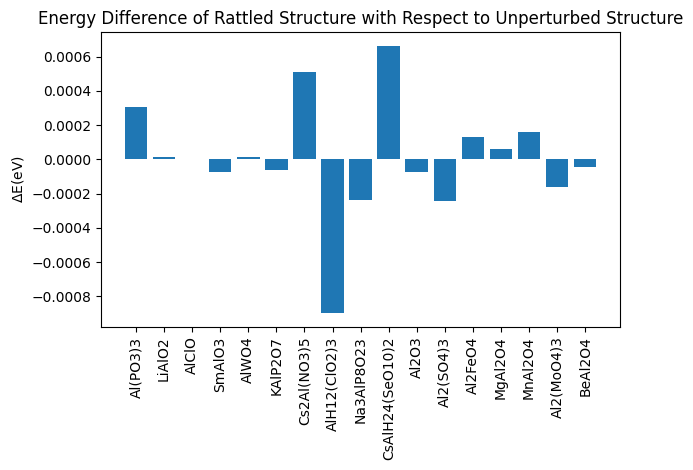

In [145]:
fig, ax = plt.subplots()
bars = ax.bar(compounds, delta_e)  # Assuming you have these lists already

# Add labels on top of each bar
ax.set_title("Energy Difference of Rattled Structure with Respect to Unperturbed Structure")
ax.set_ylabel("$\Delta$E(eV)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/energy_difference_plot.png", dpi=300, bbox_inches='tight')

plt.show()